# Benchmark

In [1]:
import shapely
import matplotlib.pyplot as plt

from fastpynuts.fastpynuts import NUTSfinder

In [2]:
from IPython.display import HTML

def compare_geoms(*geoms):
    html = "".join([geom._repr_svg_() for geom in geoms])
    return HTML(html)

In [3]:
import matplotlib.pyplot as plt
import time

scales = ["01", "03", "10", "20", "60"]
max_levels = [0, 1, 2, 3]

points = [(-2.865604, 53.406115), (-2.965604, 53.406115)]


## Benchmark Init Times

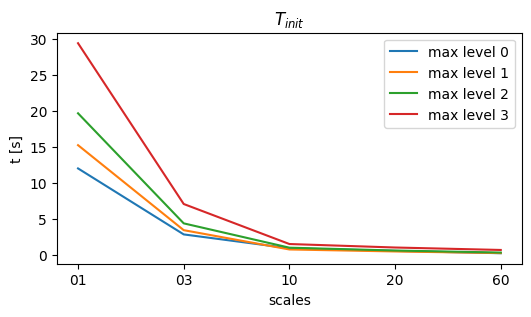

In [4]:
times_init = []
finders = []
x = range(len(scales))
plt.figure(figsize=(6,3))
for ml_ in max_levels:
    times_init_ = []
    finders_ = []
    for scale in scales:
        t0 = time.time()
        mnf = NUTSfinder(f"data/NUTS_RG_{scale}M_2021_4326.geojson", max_level=ml_)
        finders_.append(mnf)
        times_init_.append(time.time()-t0)
    plt.plot(x, times_init_, label=f"max level {ml_}")
    plt.title("$T_{init}$")
    plt.xlabel("scales")
    plt.ylabel("t [s]")
    plt.xticks(x, scales)

    times_init.append(times_init_)
    finders.append(finders_)

plt.legend()


## Benchmark Initialization Steps

In [5]:
import re

import cProfile

from io import StringIO
from pstats import Stats

# utilities
def get_stats(pr, *args, sortargs=[], verbose=True, **kwargs):
    stream = StringIO()
    stat = Stats(pr, stream=stream)
    if sortargs:
        stat.sort_stats(*sortargs).print_stats(*args, **kwargs)
    else:
        stat.print_stats(*args, **kwargs)

    value = stream.getvalue()
    if verbose: print(value)
    return value


def parse_lines(bench):
    lines = re.findall("(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(.+):(\d+)\((\w+)\)", bench, re.MULTILINE)
    parsed = [{key:val for key, val in zip(["ncalls", "tottime", "percall", "cumtime", "percall2", "file", "line", "fun"], line)} for line in lines]
    return parsed


def get_obj_name(parsed):
    with open(parsed["file"], "r") as f:
        class_n = []
        classes = []
        for num, line in enumerate(f, 1):
            if match := re.search("\w*class (.+?)([(].*:|:)", line):
                classes.append(match.group(1))
                class_n.append(num)

    target_line = int(parsed["line"])
    obj_name = [cl_ for n_, cl_ in zip(class_n, classes) if n_ < target_line][-1]
    return obj_name


def plot_benchmark(pr):
    bench = get_stats(pr, "fastpynuts", sortargs=["cumtime"], verbose=False)

    parsed = parse_lines(bench)

    # replace inits
    for parsed_ in parsed:
        if parsed_["fun"] == "__init__":
            parsed_["fun"] = get_obj_name(parsed_)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    ax, ax_rel = axs
    for i, info in enumerate(parsed):
        ax.bar(i, float(info["cumtime"]), label=" " + info["fun"])
        ax.set_title("Total Time")
        ax_rel.bar(i, float(info["percall2"]), label=" " + info["fun"])
        ax_rel.set_title("Time/Call")

    ax.set_xticks(range(len(parsed)), [p_["fun"] for p_ in parsed], rotation=30)
    ax_rel.set_xticks(range(len(parsed)), [p_["fun"] for p_ in parsed], rotation=30)


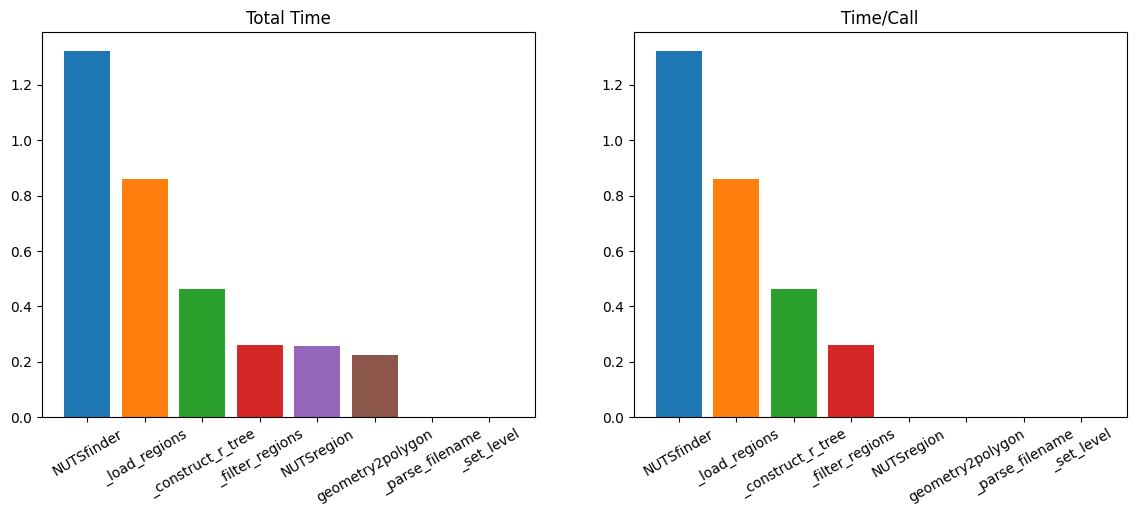

In [6]:
with cProfile.Profile() as pr: mnf_ = NUTSfinder(f"data/NUTS_RG_20M_2021_4326.geojson", max_level=ml_)
plot_benchmark(pr)

## Benchmark Querying

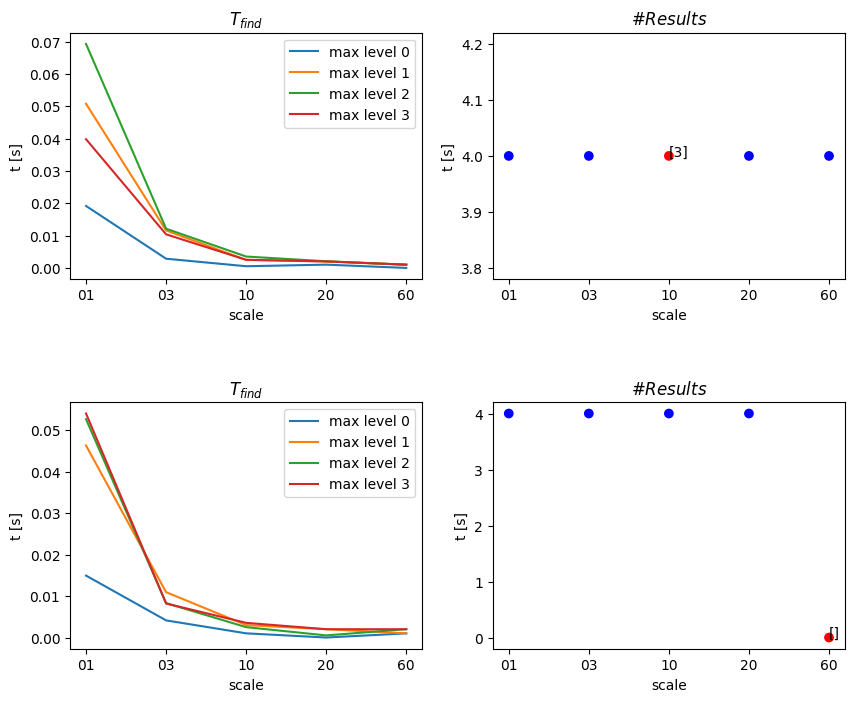

In [7]:
# compare point queries
fig, axs = plt.subplots(len(points), 2, figsize=(10, 4*len(points)), squeeze=False)
plt.subplots_adjust(hspace=0.5)
for point, axs_row in zip(points, axs):
    ax_find, ax_results = axs_row
    for maxl, finders_ in zip(max_levels, finders):
        results = []
        times_find = []
        for scale, finder in zip(scales, finders_):
            t1 = time.time()
            f = finder.find(lat=point[1], lon=point[0])
            t2 = time.time()

            times_find.append(t2-t1)
            results.append(f)

        ax_find.plot(x, times_find, label=f"max level {maxl}")
        ax_find.set_xticks(x, scales)
        ax_find.set_xlabel("scale")
        ax_find.set_ylabel("t [s]")
        ax_find.set_title("$T_{find}$")
        ax_find.legend()
    equal = [res == results[0] for res in results]
    color = ["blue" if equ else "red" for equ in equal]
    ax_results.scatter(x, [len(r) for r in results], c=color)
    for equ, x_, res in zip(equal, x, results):
        if not equ:
            wrong = [not results[0][j] == res[j] for j in range(len(res))]
            ax_results.annotate(str([i for i, wr in enumerate(wrong) if wr]), (x_, len(res)))
    ax_results.set_xticks(x, scales)
    ax_results.set_title("$\# Results$")
    ax_results.set_xlabel("scale")
    ax_results.set_ylabel("t [s]")